# Targeting high value customers based on customer demographics and attributes.
> This project was done under the umbrella of KPMG internship experience. I was provided data sets of an organization targeting a client who wants a feedback from us on their dataset quality and how this can be improved.

### Background
- Sprocket Central Pty Ltd, a medium size bikes & cycling accessories organisation
- needs help with its customer and transactions data
- how to analyse it to help optimise its marketing strategy effectively.

### Datasets
- New Customer List
- Customer Demographic
- Customer Addresses
- Transactions data in the past 3 months


### Task
- Exploratory Data Analysis to understand the data and its quality
- Model building to predict the high value customers
- Results and recommendations

In [106]:
# Importing libraries

import pandas as pd
import numpy as np
import datetime as dt

In [107]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [108]:
# Importing data
xls = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')

Transactions = pd.read_excel(xls, 'Transactions', skiprows=1)
NewCustomerList = pd.read_excel(xls, 'NewCustomerList', skiprows=1)
Demographic = pd.read_excel(xls, 'CustomerDemographic', skiprows=1)
Address = pd.read_excel(xls, 'CustomerAddress', skiprows=1)

### Checking correlation and common columns among the sheets

In [109]:
# Making variables to store the columns of each dataframe

transactions_columns = Transactions.columns
demographic_columns = Demographic.columns
newcustomerlist_columns = NewCustomerList.columns
address_columns = Address.columns

transactions_columns.name = 'transactions_columns'
demographic_columns.name = 'demographic_columns'
newcustomerlist_columns.name = 'newcustomerlist_columns'
address_columns.name = 'address_columns'

In [110]:
# A code I prompted to generate a dataframe to generate a sheet vs column presence table
# This shows if a column header is present across multiple dataframes or not

def column_comparison_table(*columns):
    """
    Generate a DataFrame to show the presence of attributes in each column.

    Args:
        *columns: Variable number of pandas DataFrame columns.

    Returns:
        A pandas DataFrame with the presence of attributes in each column.
        The column headers are based on the names of the passed columns,
        or generic names if the columns don't have names.
        The displayed columns are in the same order of the passed column arguments.
        The DataFrame is sorted based on the number of '1' values horizontally (across the rows).

    """
    # Step 1: Convert the column(s) to set(s)
    column_sets = [set(col) for col in columns]

    # Step 2: Create a set of all unique attributes from the column(s)
    all_attributes = sorted(list(set().union(*column_sets)))

    # Step 3: Create a dictionary to store the presence of attributes in each column
    presence_dict = {'Attributes': all_attributes}
    for i, col in enumerate(columns):
        column_name = col.name if col.name else f'Column {i+1}'
        presence_dict[column_name] = [1 if attr in col else 0 for attr in all_attributes]

    # Step 4: Create a DataFrame from the presence dictionary
    presence_df = pd.DataFrame(presence_dict)

    # Step 5: Sort the dataframe based on the number of '1' values horizontally (across the rows)
    presence_df = presence_df.iloc[presence_df.iloc[:, 1:].sum(axis=1).sort_values(ascending=False).index]

    # Reset the index
    presence_df = presence_df.reset_index(drop=True)

    return presence_df


In [111]:
columns_presence_df = column_comparison_table(transactions_columns, demographic_columns, address_columns,newcustomerlist_columns)
columns_presence_df

,Attributes,transactions_columns,demographic_columns,address_columns,newcustomerlist_columns
0,customer_id,1,1,1,0
1,DOB,0,1,0,1
2,first_name,0,1,0,1
3,tenure,0,1,0,1
4,state,0,0,1,1
5,property_valuation,0,0,1,1
6,postcode,0,0,1,1
7,past_3_years_bike_related_purchases,0,1,0,1
8,owns_car,0,1,0,1
9,job_title,0,1,0,1


### Highlights of the corelation analysis
We are supposed to combine the data from the three sheets (Customer Demographic, Customer Addresses, Transactions) and then make a Master Sheet which would be a training set where we would train our model to predict the high value customers.
- can use **customer_id** as the primary key to combine the data
- there are some irrelevant columns in plain sight which can be dropped
- there are rows with missing data which can be dropped as well, since it would affect the model building
- the DOB can be converted to age, and then we can perform an analysis with different age groups
- a **polynomial regression** model can be used to predict the high value customers
- values for the states, DOB and gender can be made uniform.

### Building a master Dataframe to train the model
- The master dataframe is built by combining the three sheets using the customer_id as the primary key
- The irrelevant columns are dropped
- reference for [pandas merge](https://www.youtube.com/watch?v=h4hOPGo4UVU)

In [112]:
# Merging the dataframes using customer_id as the key
merged_df = pd.merge(Demographic, Address, on='customer_id', how='outer')
master_df = pd.merge(merged_df, Transactions, on='customer_id', how='outer')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20510 entries, 0 to 20509
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          20510 non-null  int64         
 1   first_name                           20504 non-null  object        
 2   last_name                            19849 non-null  object        
 3   gender                               20504 non-null  object        
 4   past_3_years_bike_related_purchases  20504 non-null  float64       
 5   DOB                                  20047 non-null  object        
 6   job_title                            18027 non-null  object        
 7   job_industry_category                17180 non-null  object        
 8   wealth_segment                       20504 non-null  object        
 9   deceased_indicator                   20504 non-null  object        
 10  default   

In [113]:
# List of columns to drop
columns_to_drop = ['transaction_id', 'product_id', 'first_name', 'last_name', 'default', 'country','address', 'deceased_indicator']
# Create a new DataFrame by dropping the specified columns
master_stripped = master_df.drop(columns=columns_to_drop)
master_stripped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20510 entries, 0 to 20509
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          20510 non-null  int64         
 1   gender                               20504 non-null  object        
 2   past_3_years_bike_related_purchases  20504 non-null  float64       
 3   DOB                                  20047 non-null  object        
 4   job_title                            18027 non-null  object        
 5   job_industry_category                17180 non-null  object        
 6   wealth_segment                       20504 non-null  object        
 7   owns_car                             20504 non-null  object        
 8   tenure                               20047 non-null  float64       
 9   postcode                             20478 non-null  float64       
 10  state     

### Making the dates uniform and adding the age column

In [114]:
# Making the DOB and transaction_date columns into datetime objects
master_stripped['DOB'] = pd.to_datetime(master_stripped['DOB'])
master_stripped['transaction_date'] = pd.to_datetime(master_stripped['transaction_date'])

In [115]:
# Define the start and end dates of the dataset
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

# Convert "DOB" column to datetime format
master_stripped['DOB'] = pd.to_datetime(master_stripped['DOB'])

# Calculate customer age based on "DOB" column
master_stripped['customer_age'] = ((end_date - master_stripped['DOB']).dt.days // 365.25)


In [116]:
# Fix the Product First sold date and add a product age column
master_stripped['product_first_sold_date'] = pd.to_timedelta(master_stripped['product_first_sold_date'], unit='D') + pd.Timestamp('1900-01-01')
today_date = pd.Timestamp('2018-01-01')
date_difference = pd.Timestamp.today() - today_date

master_stripped['product_first_sold_date'] = master_stripped['product_first_sold_date'] - date_difference

master_stripped['product_age'] = ((today_date - master_stripped['product_first_sold_date']).dt.days // 365.25)

In [117]:
master_stripped.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,...,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,customer_age,product_age
0,1,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016.0,...,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,1999-10-11 03:11:34.103153,64.0,18.0
1,1,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016.0,...,Approved,Solex,Standard,medium,medium,1577.53,826.51,2002-08-20 03:11:34.103153,64.0,15.0
2,1,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016.0,...,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,1997-12-21 03:11:34.103153,64.0,20.0
3,1,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016.0,...,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,1998-02-09 03:11:34.103153,64.0,19.0
4,1,F,93.0,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11.0,2016.0,...,Approved,Solex,Standard,medium,medium,71.49,53.62,2000-01-10 03:11:34.103153,64.0,17.0


### Making the States and Genders uniform

In [118]:
# Replace 'New South Wales' with 'NSW' and Victoria with 'VIC'
master_stripped['state'] = master_stripped['state'].replace('New South Wales', 'NSW')
master_stripped['state'] = master_stripped['state'].replace('Victoria', 'VIC')

# Replace 'Female'and 'Femal' with 'F' and 'Male' with 'M'
master_stripped['gender'] = master_stripped['gender'].replace('Female', 'F')
master_stripped['gender'] = master_stripped['gender'].replace('Femal', 'F')
master_stripped['gender'] = master_stripped['gender'].replace('Male', 'M')

# Replace 'U' with np.nan
master_stripped['gender'] = master_stripped['gender'].replace('U', np.nan)


In [119]:
# Obtain the unique values of the "state" and the gender columns
states = master_stripped['state'].unique()
genders = master_stripped['gender'].unique()

In [120]:
print(states)
print(genders)

['NSW' nan 'QLD' 'VIC']
['F' 'M' nan]


### Converting the non Boolean values to Boolean values

In [121]:
# Fixing the owns_car column

# Step 1: Replace blank values with NaN
master_stripped['owns_car'].replace('', pd.NA, inplace=True)

# Step 2: Convert 'Yes' to True and 'No' to False
mapping = {'Yes': True, 'No': False}
master_stripped['owns_car'] = master_stripped['owns_car'].map(mapping)

# Step 3: Fill NaN values with False
master_stripped['owns_car'].fillna(False, inplace=True)

In [122]:
# Fixing the owns_car column

# Step 1: Replace blank values with NaN
master_stripped['order_status'].replace('', pd.NA, inplace=True)

# Step 2: Convert 'Yes' to True and 'No' to False
mapping = {'Approved': True, 'Cancelled': False}
master_stripped['order_status'] = master_stripped['order_status'].map(mapping)

# Step 3: Fill NaN values with False
master_stripped['order_status'].fillna(False, inplace=True)

In [123]:
# Fixing the online_order column
# Step 1: Replace blank values with NaN
master_stripped['online_order'].replace('', pd.NA, inplace=True)

# Step 2: Convert the column to boolean type
master_stripped['online_order'] = master_stripped['online_order'].astype('boolean')

### Fixing bad floats

In [124]:
master_stripped['tenure'] = master_stripped['tenure'].astype('Int64')
master_stripped['past_3_years_bike_related_purchases'] = master_stripped['past_3_years_bike_related_purchases'].astype('Int64')
master_stripped['postcode'] = master_stripped['postcode'].astype('Int64')
master_stripped['property_valuation'] = master_stripped['property_valuation'].astype('Int64')
master_stripped['customer_age'] = master_stripped['customer_age'].astype('Int64')

In [125]:
master_stripped.to_csv('master_stripped.csv', index=False)

### Analysing Null Values of the Master Dataframe

In [126]:
# Function to analyse the missing data

def analyze_null_values(dataframe):
    total_null_values = dataframe.isnull().sum()
    total_values = dataframe.count().sort_values(ascending=True)
    null_values_percentage = (total_null_values / total_values) * 100
    missing_data = pd.concat(
        {'Null Values': total_null_values, 'Total Values': total_values, 'Percentage of Missing Values': null_values_percentage},
        axis=1
    )
    
    missing_data = missing_data.sort_values(by='Percentage of Missing Values', ascending=False)
    
    return missing_data


In [127]:
analyze_null_values(master_stripped)

,Null Values,Total Values,Percentage of Missing Values
job_industry_category,3330,17180,19.383003
job_title,2483,18027,13.773784
online_order,870,19640,4.429735
product_age,707,19803,3.570166
product_first_sold_date,707,19803,3.570166
standard_cost,707,19803,3.570166
product_size,707,19803,3.570166
product_class,707,19803,3.570166
product_line,707,19803,3.570166
brand,707,19803,3.570166


In [128]:
# Making a datset with the dropped null values
master_null = master_stripped.dropna()
analyze_null_values(master_null)

,Null Values,Total Values,Percentage of Missing Values
customer_id,0,14054,0.0
gender,0,14054,0.0
customer_age,0,14054,0.0
product_first_sold_date,0,14054,0.0
standard_cost,0,14054,0.0
list_price,0,14054,0.0
product_size,0,14054,0.0
product_class,0,14054,0.0
product_line,0,14054,0.0
brand,0,14054,0.0


### Highlights of the Null Values Analysis
- job_title and job_industry_category have a lot of null values
- we can make two models, one where the job_title and job_industry_category are dropped, and one where they are not dropped
- learn about RFM analysis and KDD method
- followed a tutorial, the guy dropped all the null values no questions asked.

### Creating a profit column
This would be used for the M value in the RFM analysis

In [129]:
master_null['profit'] = master_null['list_price'] - master_null['standard_cost']
master_null.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,...,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,customer_age,product_age,profit
0,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,OHM Cycles,Standard,medium,medium,235.63,125.07,1999-10-11 03:11:34.103153,64,18.0,110.56
1,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,Solex,Standard,medium,medium,1577.53,826.51,2002-08-20 03:11:34.103153,64,15.0,751.02
2,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,Trek Bicycles,Road,low,small,1720.70,1531.42,1997-12-21 03:11:34.103153,64,20.0,189.28
3,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,Norco Bicycles,Standard,medium,medium,360.40,270.30,1998-02-09 03:11:34.103153,64,19.0,90.10
4,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,Solex,Standard,medium,medium,71.49,53.62,2000-01-10 03:11:34.103153,64,17.0,17.87


### Creating a Transaction Day, Week, Month Column

In [130]:
master_null['transaction_day'] = master_null['transaction_date'].dt.strftime('%A')
master_null['transaction_month'] = master_null['transaction_date'].dt.strftime('%B')

### Creating the RFM table

In [131]:
# We already have the Monetary value (profit) of each customer
# Preparing the Recency Value

master_null['recency'] = (today_date - master_null['transaction_date']).dt.days
master_null['frequency'] = master_null.groupby('customer_id')['customer_id'].transform('count')
master_null.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,postcode,...,list_price,standard_cost,product_first_sold_date,customer_age,product_age,profit,transaction_day,transaction_month,recency,frequency
0,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,235.63,125.07,1999-10-11 03:11:34.103153,64,18.0,110.56,Saturday,December,9,11
1,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,1577.53,826.51,2002-08-20 03:11:34.103153,64,15.0,751.02,Thursday,April,270,11
2,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,1720.70,1531.42,1997-12-21 03:11:34.103153,64,20.0,189.28,Thursday,May,235,11
3,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,360.40,270.30,1998-02-09 03:11:34.103153,64,19.0,90.10,Thursday,January,361,11
4,1,F,93,1953-10-12,Executive Secretary,Health,Mass Customer,True,11,2016,...,71.49,53.62,2000-01-10 03:11:34.103153,64,17.0,17.87,Tuesday,February,314,11


Now that we have the RFM Values of each customer, we can make a new RFM Dataframe and use it to make clusters of the customers, and later use it to map to customer IDs and predict the high value customers.

In [132]:
rfm_table = master_null.groupby('customer_id').agg({'recency': lambda x: x.min(), 'frequency': lambda x: x.count(), 'profit': lambda x: x.sum()})
rfm_table.rename(columns={'recency': 'recency_value', 'frequency': 'frequency_value', 'profit': 'monetary_value'}, inplace=True)

### Using KMeans to make clusters
- Write a function to scale the features (use standard scaler)
- Write a function to fit the KMeans algorithm on the scaled features and return the model as well as the predictions
- Make sure to run this only on the clean rfm dataframe

In [133]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def plot_elbow_method(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)

    inertia = []
    for i in np.arange(1, 11):
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=1) # n_init is the number of times the K-mean algorithm will run with different centroid seeds (default=10), explicityly set to 10 to suppress warning
        kmeans.fit(scaled)
        inertia.append(kmeans.inertia_)

    plt.plot(np.arange(1, 11), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    return scaled

# Example usage:
# Assuming you have a DataFrame called 'rfm_table', you can call the function like this:
# plot_elbow_method(rfm_table)

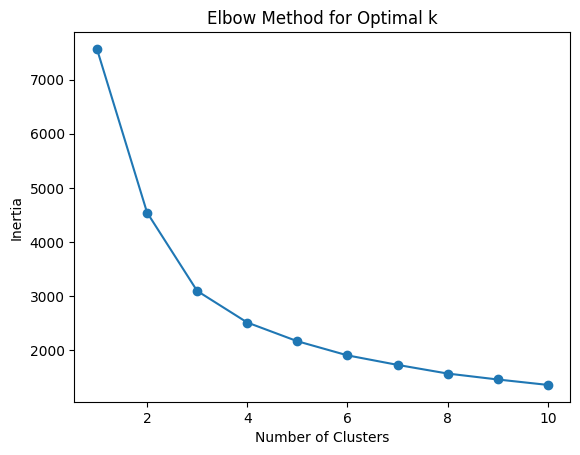

In [134]:
scaled_array = plot_elbow_method(rfm_table)

Seems like the optimal number of clusters is 3, we'll then classify each unique customer into one of these 3 clusters.

In [135]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=1)
kmeans.fit(scaled_array)

# +1 to make the clusters start from 1 instead of 0
rfm_table['cluster'] = kmeans.labels_+1
rfm_table

,recency_value,frequency_value,monetary_value,cluster
customer_id,,,,
1,9,11,3018.09,3
2,130,3,2226.26,2
9,80,6,2353.11,1
12,69,7,3540.03,3
13,29,7,4337.38,3
...,...,...,...,...
3493,95,6,3728.88,1
3494,6,4,2755.11,1
3495,15,7,3847.65,3


Now that we have the clusters, we will analyse the clusters and see which cluster has the highest profit, and then we will map the customer IDs to the clusters and then predict the high value customers.

In [136]:
cluster_map = rfm_table.groupby('cluster').agg({'recency_value': 'mean', 'frequency_value': 'mean', 'monetary_value': 'mean'})
cluster_map["cluster_size"] = rfm_table.groupby('cluster')['cluster'].count()
cluster_map

,recency_value,frequency_value,monetary_value,cluster_size
cluster,,,,
1,44.075218,4.698337,2285.554592,1263
2,171.674699,3.412048,1733.392410,415
3,43.142180,7.943128,4912.432002,844


It's obvious that the cluster 1 customers are the high value customers, then cluster 2 and then cluster 3.

There are comparatively less customers in cluster 1, but they have the highest profit, given cluster two customers are the most in number but struggle to keep up with the profits of cluster 1 customers.

In [137]:
import plotly.express as px

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    rfm_table,
    x='recency_value',
    y='frequency_value',
    z='monetary_value',
    color='cluster',
    size_max=10,
    opacity=0.7,
    labels={'recency_value': 'Recency', 'frequency_value': 'Frequency', 'monetary_value': 'Monetary'},
    title='RFM Clusters - Interactive 3D Scatter Plot'
)

fig.show()

In [138]:
# Mapping the clusters to the customers
master_null['cluster'] = master_null['customer_id'].map(rfm_table['cluster'])

### Predicting the high value customers
Now that we have the clusters, we will map the customer IDs to the clusters and then predict the high value customers.
To do this
- Our target is to check what demographic brings out the most cluster 1 type of customers
- We will use the customer demographic sheet for this, and make age groups and then check which age group has the most cluster 1 customers
- Similarly what job titles and job industries bring out the most cluster 1 customers
- And what city and state brings out the most cluster 1 customers
- And since we are doing this, we will make a graph for all the clusters and not just cluster 1

In [139]:
# Pie chart for finding out the distribution of genders among the clusters
master_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14054 entries, 0 to 19984
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          14054 non-null  int64         
 1   gender                               14054 non-null  object        
 2   past_3_years_bike_related_purchases  14054 non-null  Int64         
 3   DOB                                  14054 non-null  datetime64[ns]
 4   job_title                            14054 non-null  object        
 5   job_industry_category                14054 non-null  object        
 6   wealth_segment                       14054 non-null  object        
 7   owns_car                             14054 non-null  bool          
 8   tenure                               14054 non-null  Int64         
 9   postcode                             14054 non-null  Int64         
 10  state          